In [12]:
import random
import time

import matplotlib.pyplot as plt
import pandas as pd
import torch

from vladk_neural_network.model.activation import LeakyRelu, Linear
from vladk_neural_network.model.base import NeuralNetwork
from vladk_neural_network.model.layer import (
    Convolutional,
    Flatten,
    FullyConnected,
    Input,
    Input3D,
    MaxPool2D,
)
from vladk_neural_network.model.loss import CategoricalCrossEntropy
from vladk_neural_network.model.metric import AccuracyOneHot
from vladk_neural_network.model.optimizer import Adam

## Helper functions for displaying changes in loss and Accuracy with the change of epochs

In [13]:
def plot_loss(epoch, train_loss, test_loss, title):
    plt.figure(figsize=(10, 8))
    plt.plot(epoch, train_loss, color='r', label='Train')
    plt.plot(epoch, test_loss, color='g', label='Test')
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_accuracy_score(epoch, train_metric, test_metric, title):
    plt.figure(figsize=(10, 8))
    plt.plot(epoch, train_metric, color='r', label='Train')
    plt.plot(epoch, test_metric, color='g', label='Test')
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.show()

## Function to display selected digit

In [14]:
def plot_digit(image, digit):
    image = torch.tensor(image).numpy().reshape(28, 28)
    plt.figure()
    plt.imshow(image, cmap="gray")
    plt.title(f"Predicted digit: {digit}")
    plt.axis("off")
    plt.show()

    return

## Function to display selected digit from cnn dataset 

In [15]:
def plot_digit_cnn(image, digit):
    image = torch.tensor(image).numpy()
    plt.figure()
    plt.title(f"Predicted digit: {digit}")
    plt.imshow(image, cmap="gray")
    plt.axis("off")
    plt.show()

    return

## Helper function to get one-hot array for digit

In [16]:
def get_digit(onehot_array):
    for index, value in enumerate(onehot_array):
        if value == 1.0:
            return index
    return None

## Helper function to get digit by one-hot arrary

In [17]:
def get_onehot_digit(digit):
    output = [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
    return output[-digit:] + output[:-digit]

# 1. Classification on digits dataset using simple NN

## Function to get digits train/test data

In [18]:
def get_digits_data():

    dataset = []

    train = pd.read_csv("../data/digits/train.csv", header=0, nrows=10000)

    for index in train.index:
        input_values = [
            float(val) / 255.0 for val in train.loc[index].drop("label").values
        ]
        dataset.append(
            {
                "input": input_values,
                "output": get_onehot_digit(int(train.loc[index]["label"])),
            }
        )

    random.seed(3)
    random.shuffle(train_dataset)
    return dataset[:2000], dataset[2000:2500]

## Create simple NN model for classification on digits dataset and test

Epoch: 1/15, train loss: 2.0523, train Accuracy: 0.6575, test loss: 1.876, test Accuracy: 0.864, epoch time: 1.957s
Epoch: 2/15, train loss: 1.7872, train Accuracy: 0.8995, test loss: 1.7554, test Accuracy: 0.892, epoch time: 1.994s
Epoch: 3/15, train loss: 1.6915, train Accuracy: 0.943, test loss: 1.7157, test Accuracy: 0.918, epoch time: 1.877s
Epoch: 4/15, train loss: 1.6423, train Accuracy: 0.966, test loss: 1.6722, test Accuracy: 0.924, epoch time: 1.873s
Epoch: 5/15, train loss: 1.6085, train Accuracy: 0.9745, test loss: 1.6624, test Accuracy: 0.924, epoch time: 1.911s
Epoch: 6/15, train loss: 1.5844, train Accuracy: 0.989, test loss: 1.6407, test Accuracy: 0.926, epoch time: 1.909s
Epoch: 7/15, train loss: 1.5635, train Accuracy: 0.9915, test loss: 1.6268, test Accuracy: 0.932, epoch time: 2.018s
Epoch: 8/15, train loss: 1.5471, train Accuracy: 0.995, test loss: 1.6306, test Accuracy: 0.93, epoch time: 1.918s
Epoch: 9/15, train loss: 1.534, train Accuracy: 0.997, test loss: 1.61

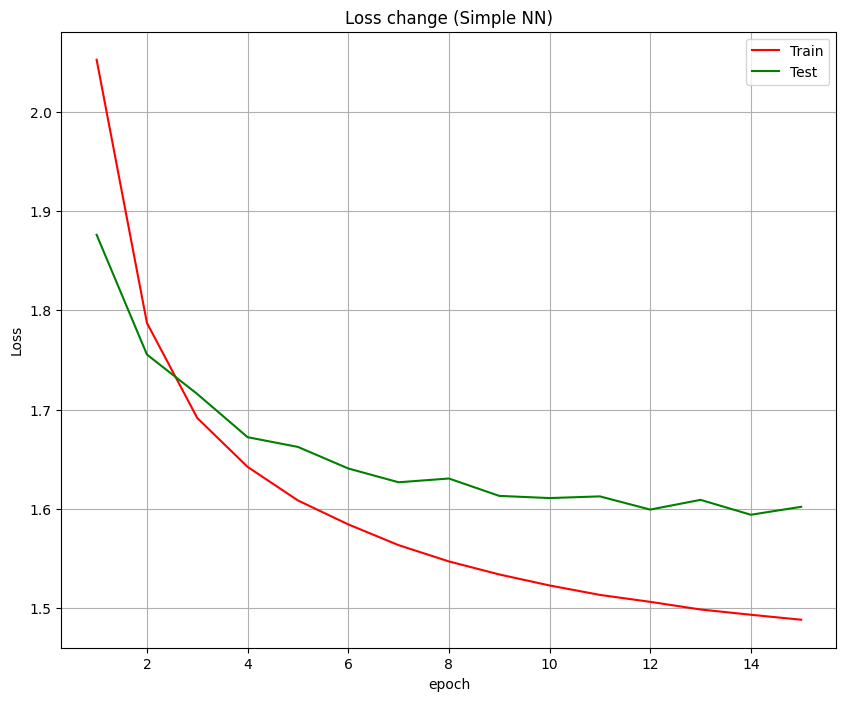

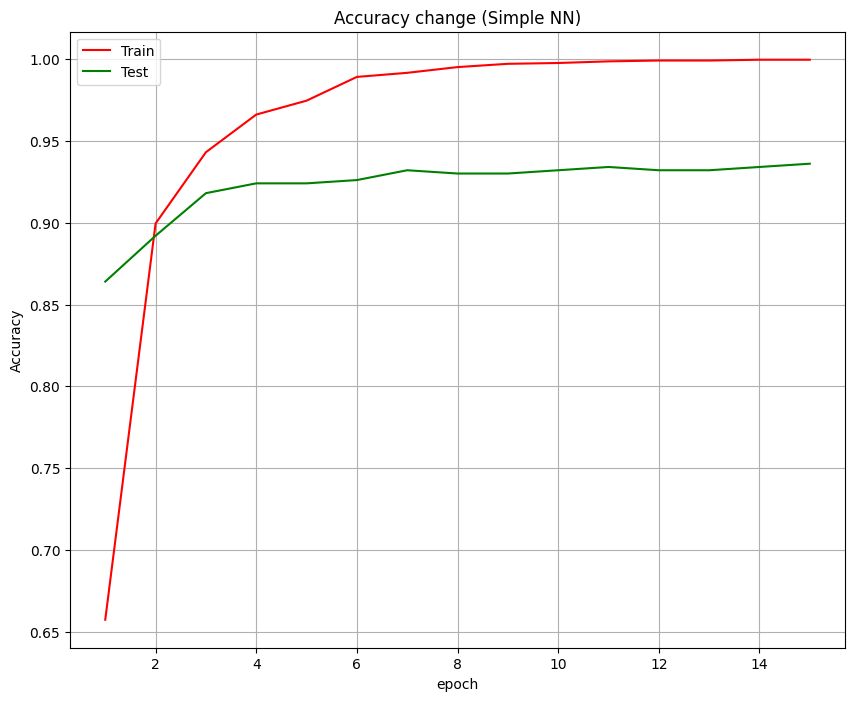

In [19]:
train_dataset, test_dataset = get_digits_data()

layers = [
    FullyConnected(512, LeakyRelu()),
    FullyConnected(128, LeakyRelu()),
    FullyConnected(32, LeakyRelu()),
    FullyConnected(10, Linear()),
]
nn = NeuralNetwork(
    Input(784),
    layers,
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossEntropy(),
    metric=AccuracyOneHot(),
    convert_prediction="argmax"
)

start_time = time.time()

epochs = 15
history = nn.fit(train_dataset, test_dataset, epochs=epochs, batch_size=8, verbose=True)

print("--- %s seconds ---" % (time.time() - start_time))

prediction = nn.predict(test_dataset)

epoch = [epoch_data['epoch'] for epoch_data in history]
train_loss = [epoch_data['train_loss'] for epoch_data in history]
test_loss = [epoch_data['test_loss'] for epoch_data in history]
train_metric = [epoch_data['train_metric'] for epoch_data in history]
test_metric = [epoch_data['test_metric'] for epoch_data in history]

plot_loss(epoch, train_loss, test_loss, "Loss change (Simple NN)")
plot_accuracy_score(epoch, train_metric, test_metric, "Accuracy change (Simple NN)")

## First ten test digits with predicted values (Simple NN)

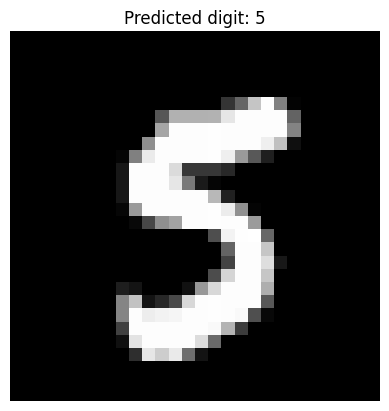

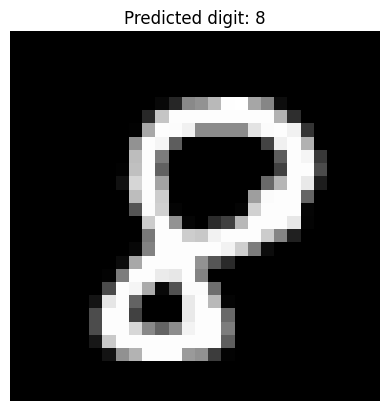

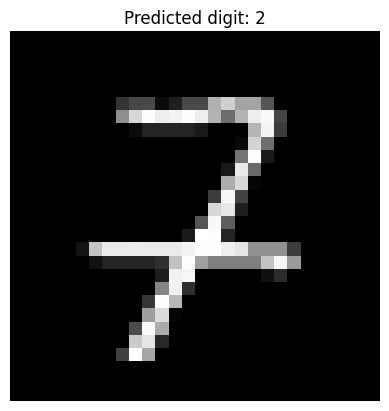

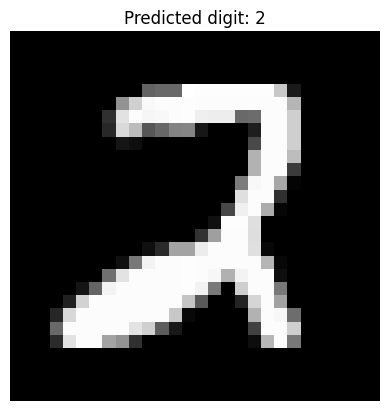

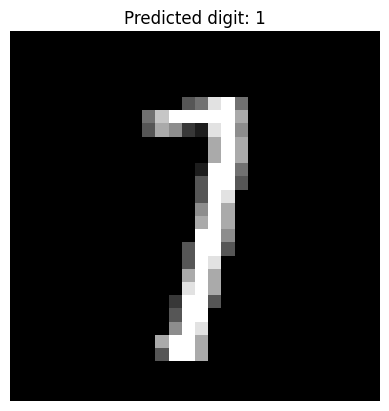

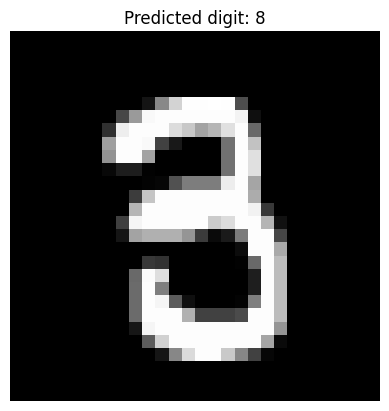

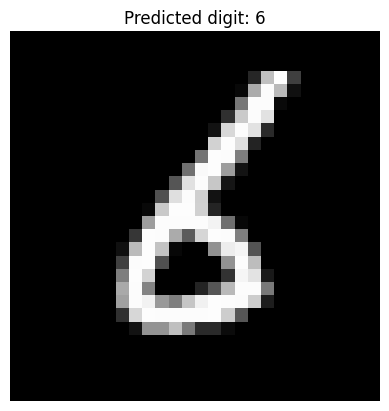

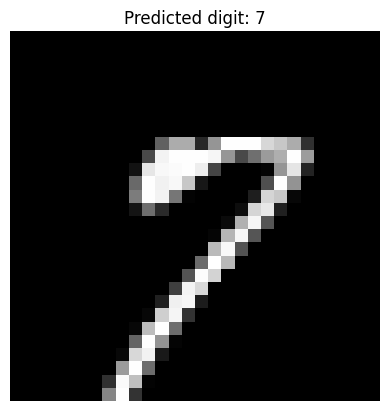

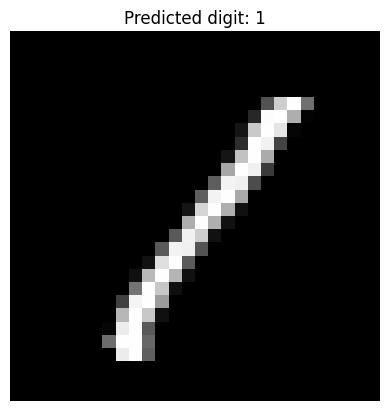

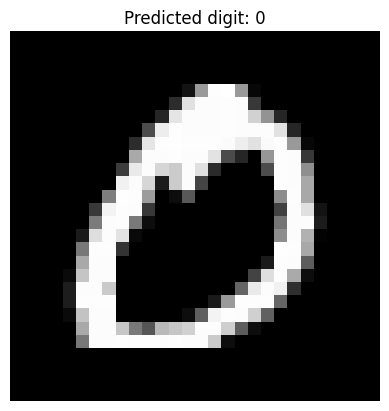

In [20]:
for index, predicted_digit in enumerate(prediction[:10]):
    plot_digit(test_dataset[index]['input'], get_digit(predicted_digit))

# 2. Classification on digits dataset using convolutional NN

## Function to get digits train/test data for CNN model

In [21]:
def get_digits_data_cnn():

    dataset = []

    train = pd.read_csv("../data/digits/train.csv", header=0, nrows=10000)

    for index in train.index:
        input_values = [
            float(val) / 255.0 for val in train.loc[index].drop("label").values
        ]
        dataset.append(
            {
                "input": [torch.tensor(input_values).reshape(28, 28).tolist()],
                "output": get_onehot_digit(int(train.loc[index]["label"])),
            }
        )

    random.seed(3)
    random.shuffle(dataset)
    return dataset[:2000], dataset[2000:2500]

## Create convolutional NN model for classification on digits dataset and test

Epoch: 1/15, train loss: 1.7868, train Accuracy: 0.8155, test loss: 1.6648, test Accuracy: 0.936, epoch time: 7.497s
Epoch: 2/15, train loss: 1.6087, train Accuracy: 0.959, test loss: 1.6552, test Accuracy: 0.946, epoch time: 7.158s
Epoch: 3/15, train loss: 1.574, train Accuracy: 0.968, test loss: 1.6164, test Accuracy: 0.966, epoch time: 6.859s
Epoch: 4/15, train loss: 1.549, train Accuracy: 0.985, test loss: 1.5862, test Accuracy: 0.968, epoch time: 7.085s
Epoch: 5/15, train loss: 1.5313, train Accuracy: 0.989, test loss: 1.576, test Accuracy: 0.972, epoch time: 7.462s
Epoch: 6/15, train loss: 1.5152, train Accuracy: 0.9955, test loss: 1.6053, test Accuracy: 0.972, epoch time: 7.15s
Epoch: 7/15, train loss: 1.5059, train Accuracy: 0.997, test loss: 1.5539, test Accuracy: 0.966, epoch time: 6.95s
Epoch: 8/15, train loss: 1.5019, train Accuracy: 0.9965, test loss: 1.6142, test Accuracy: 0.97, epoch time: 6.948s
Epoch: 9/15, train loss: 1.4942, train Accuracy: 0.998, test loss: 1.5935, 

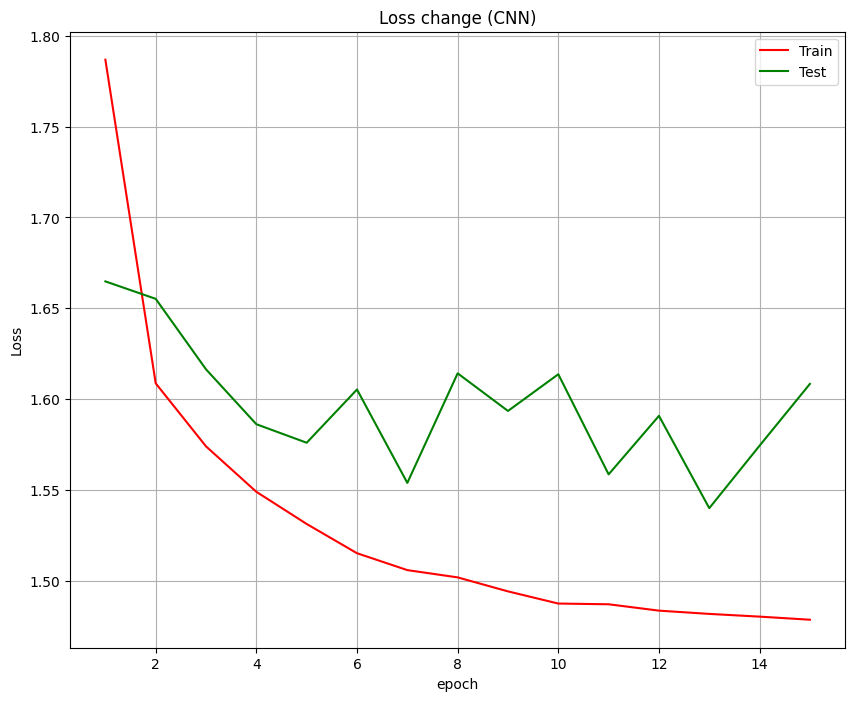

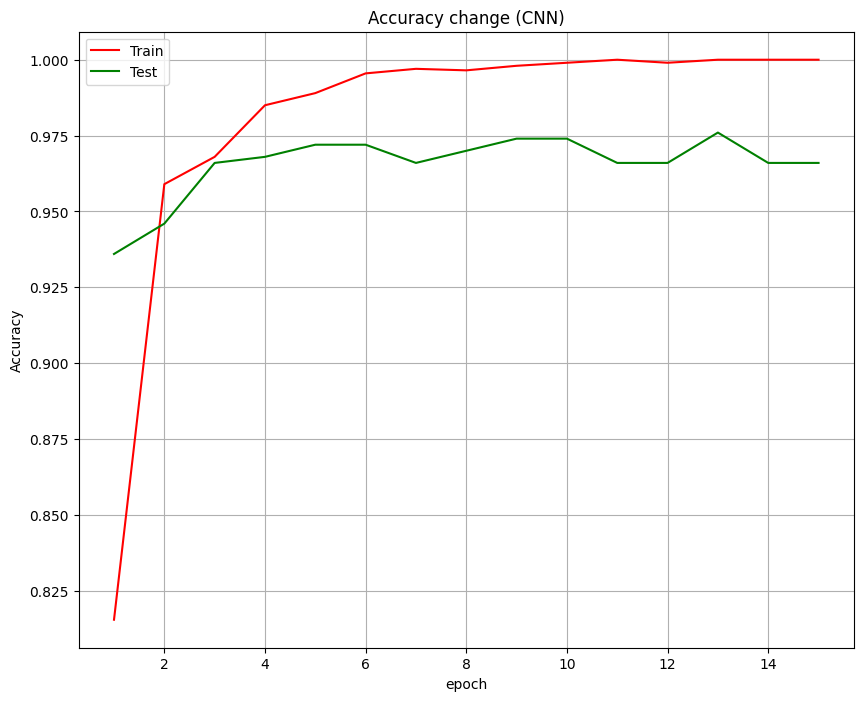

In [22]:
train_data, test_data = get_digits_data_cnn()

layers = [
    Convolutional(LeakyRelu(), filters_num=4, kernel_size=3, padding_type="same"),
    Convolutional(LeakyRelu(), filters_num=8, kernel_size=3),
    Convolutional(LeakyRelu(), filters_num=16, kernel_size=3),
    MaxPool2D(),
    Flatten(),
    FullyConnected(64, LeakyRelu()),
    FullyConnected(10, Linear()),
]
cnn = NeuralNetwork(
    Input3D((1, 28, 28)),
    layers,
    optimizer=Adam(learning_rate=0.001),
    loss=CategoricalCrossEntropy(),
    metric=AccuracyOneHot(),
    convert_prediction='argmax',
    use_gpu=True
)

start_time = time.time()

epochs = 15
history = cnn.fit(train_data, test_data, epochs=epochs, batch_size=1, verbose=True)

print("--- %s seconds ---" % (time.time() - start_time))

prediction = cnn.predict(test_data)

epoch = [epoch_data['epoch'] for epoch_data in history]
train_loss = [epoch_data['train_loss'] for epoch_data in history]
test_loss = [epoch_data['test_loss'] for epoch_data in history]
train_metric = [epoch_data['train_metric'] for epoch_data in history]
test_metric = [epoch_data['test_metric'] for epoch_data in history]

plot_loss(epoch, train_loss, test_loss, "Loss change (CNN)")
plot_accuracy_score(epoch, train_metric, test_metric, "Accuracy change (CNN)")

## First ten test digits with predicted values (CNN)

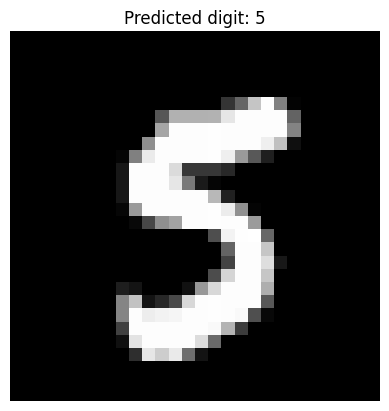

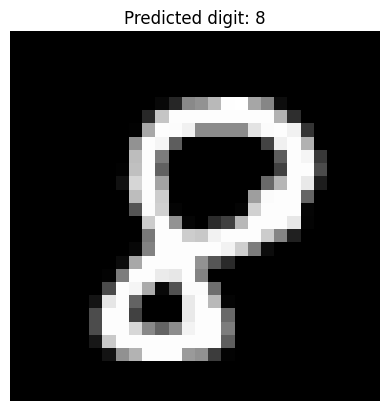

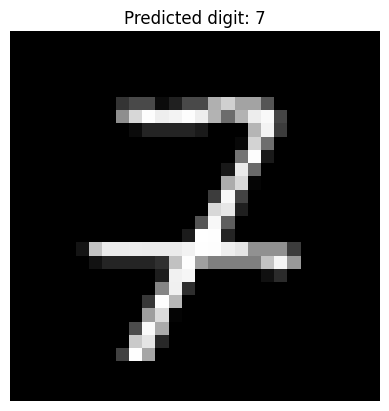

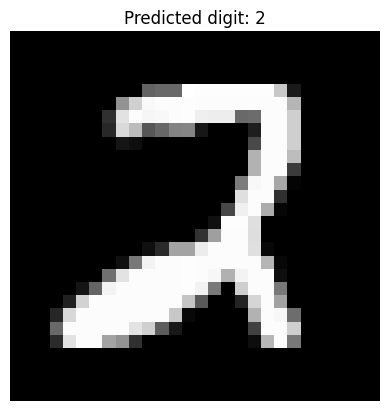

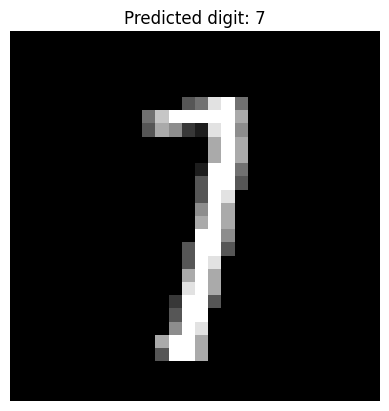

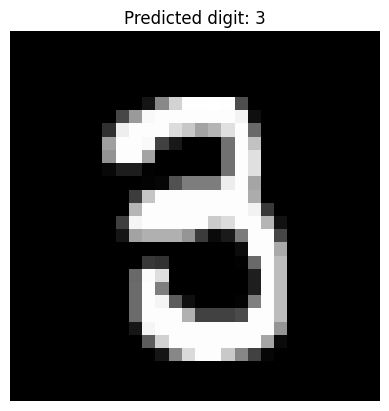

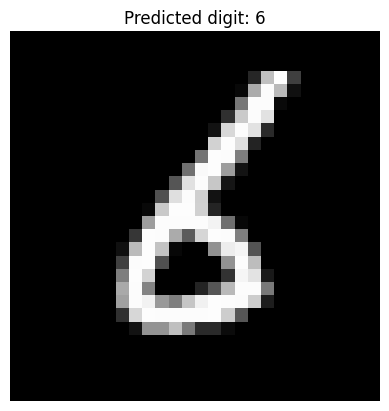

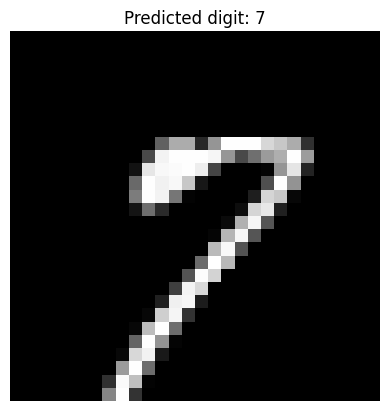

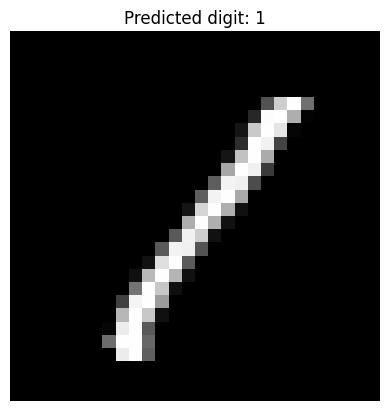

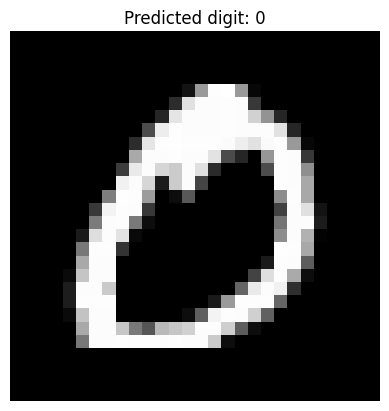

In [23]:
for index, predicted_digit in enumerate(prediction[:10]):
    plot_digit_cnn(test_data[index]['input'][0], get_digit(predicted_digit))